In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Check train folder
print("Train Data:")
print(os.listdir('/content/drive/My Drive/chest_xray/train'))

# Check test folder
print("Test Data:")
print(os.listdir('/content/drive/My Drive/chest_xray/test'))

# Check val folder
print("Val Data:")
print(os.listdir('/content/drive/My Drive/chest_xray/val'))

Train Data:
['PNEUMONIA', 'NORMAL']
Test Data:
['NORMAL', 'PNEUMONIA']
Val Data:
['PNEUMONIA', 'NORMAL']


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers, models
from plotly.subplots import make_subplots
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from PIL import Image
import plotly.offline as pyo
from IPython.display import display
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from collections import Counter
from tqdm import tqdm
import random

In [ ]:
train_dir = '/content/drive/My Drive/chest_xray/train'
test_dir = '/content/drive/My Drive/chest_xray/test'
val_dir = '/content/drive/My Drive/chest_xray/val'

# Data Description and EDA

In [ ]:
# Define categories
categories = ['PNEUMONIA', 'NORMAL']

# Count the number of images in each category
category_counts = {}

for category in categories:
    category_path = os.path.join(train_dir, category)
    if os.path.exists(category_path):  # Check if the path exists
        num_images = len(os.listdir(category_path))
        category_counts[category] = num_images
    else:
        print(f"Path not found: {category_path}")

# Display category counts
print("Number of images in each category:")
for category, count in category_counts.items():
    print(f"{category}: {count}")

Number of images in each category:
PNEUMONIA: 3923
NORMAL: 1365


In [ ]:
## Visualising Number of Images in Each Category

fig = go.Figure()

# Add bar chart with labels
fig.add_trace(go.Bar(
    x=list(category_counts.keys()),
    y=list(category_counts.values()),
    marker_color=['blue', 'green',],
    text=list(category_counts.values()),  # Add labels
    textposition='auto'  # Display labels on top of the bars
))

# Customize layout
fig.update_layout(
    title="Image Distribution by Category",
    xaxis_title="Category",
    yaxis_title="Number of Images",
    xaxis_tickangle=20,
    font=dict(size=12),
    yaxis=dict(gridcolor='rgba(127,127,127,0.3)')  # Add gridlines
)

# Show the figure
fig.show()

In [ ]:
import os
from tqdm import tqdm
from PIL import Image
import numpy as np
import plotly.express as px

# Initialize a list to store image sizes
image_sizes = []

# Function to collect image sizes from a directory with a progress bar
def collect_image_sizes(directory, dataset_name):
    """
    Collects image resolutions from a directory and associates them with a dataset name.
    """
    print(f"Collecting image sizes for {dataset_name}...")
    for root, dirs, files in tqdm(os.walk(directory), desc=f"Processing {dataset_name}"):
        for file in files:
            if file.endswith('.jpeg'):  # Ensure only JPEG files are processed
                image_path = os.path.join(root, file)
                try:
                    with Image.open(image_path) as img:
                        # Append the (width, height, dataset name) to the list
                        image_sizes.append((img.size[0], img.size[1], dataset_name))
                except Exception as e:
                    print(f"Error processing file {image_path}: {e}")

# Collect image sizes from train, test, and val directories
collect_image_sizes(train_dir, "Train")
collect_image_sizes(test_dir, "Test")
collect_image_sizes(val_dir, "Validation")

# Convert image sizes to a NumPy array for easy manipulation
resolutions = np.array(image_sizes, dtype=object)

# Create a scatter plot figure with Plotly
fig = px.scatter(
    x=resolutions[:, 0].astype(int),  # Widths
    y=resolutions[:, 1].astype(int),  # Heights
    color=resolutions[:, 2],          # Dataset names
    title="Distribution of Image Resolutions Across Datasets",
    labels={"x": "Width (pixels)", "y": "Height (pixels)", "color": "Dataset"},
    hover_name=[f"{w}x{h} ({d})" for w, h, d in resolutions]  # Resolutions and dataset
)

# Customize the plot
fig.update_layout(
    showlegend=True,
    hovermode="closest",
    width=900,
    height=600,
    margin=dict(l=50, r=50, b=50, t=50, pad=4)
)

# Show the plot
fig.show()


Processing Train: 3it [01:06, 22.28s/it]


Processing Test: 3it [00:13,  4.48s/it]


Processing Validation: 3it [00:11,  3.99s/it]


Conclusion:
1. The dataset suffers from class imbalance, the `normal` class being underrepresented.
2. Images in the dataset vary in size, requiring standardization.

Solutions:
1. Data Augmentation: Apply techniques such as rotation, flipping, and zooming to increase the representation of underrepresented categories.
2. Image Resizing: Normalize all images to a consistent size for uniform processing.

# Data Proprocessing

### Image Resizing


In [ ]:
import os
import cv2
from tqdm import tqdm

# Parameters
img_size = 150  # Resize all images to 150x150

def resize_and_save_images(input_dir, output_dir, img_size, categories):
    """
    Resize images and save them to specified directories with the correct structure.

    Parameters:
    - input_dir (str): Directory containing original images.
    - output_dir (str): Directory to save resized images.
    - img_size (int): Desired image size (width and height).
    - categories (list): List of category names (e.g., ['NORMAL', 'PNEUMONIA']).
    """
    for category in categories:
        input_category_dir = os.path.join(input_dir, category)
        output_category_dir = os.path.join(output_dir, category)

        # Ensure the output category directory exists
        os.makedirs(output_category_dir, exist_ok=True)

        # Check if the input category directory exists
        if not os.path.exists(input_category_dir):
            print(f"Warning: {category} folder does not exist in {input_dir}. Skipping...")
            continue

        # Process each image in the current category folder
        for filename in tqdm(os.listdir(input_category_dir), desc=f"Processing {category} in {os.path.basename(input_dir)}"):
            img_path = os.path.join(input_category_dir, filename)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (img_size, img_size))  # Resize to specified size
                    # Change the extension to .jpg before saving
                    output_filename = os.path.splitext(filename)[0] + '.jpg'  # Replace extension with .jpg
                    output_path = os.path.join(output_category_dir, output_filename)
                    cv2.imwrite(output_path, img)  # Save as .jpg
                else:
                    print(f"Warning: Failed to read image: {img_path}")
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    print(f"Image resizing and saving completed for {input_dir}!")

# Define directories for original data and resized images
input_base_dir = '/content/drive/My Drive/chest_xray'
output_base_dir = '/content/drive/My Drive/chest_xray_resized'

# Directories for train, test, and validation datasets
train_dir = os.path.join(input_base_dir, 'train')
test_dir = os.path.join(input_base_dir, 'test')
val_dir = os.path.join(input_base_dir, 'val')

train_data_resized = os.path.join(output_base_dir, 'Training')
test_data_resized = os.path.join(output_base_dir, 'Testing')
val_data_resized = os.path.join(output_base_dir, 'Validation')

# Categories for pneumonia dataset
categories = ['NORMAL', 'PNEUMONIA']

# Resize and save images for training dataset
print("Resizing Training Dataset...")
resize_and_save_images(train_dir, train_data_resized, img_size, categories)

# Resize and save images for testing dataset
print("\nResizing Testing Dataset...")
resize_and_save_images(test_dir, test_data_resized, img_size, categories)

# Resize and save images for validation dataset
print("\nResizing Validation Dataset...")
resize_and_save_images(val_dir, val_data_resized, img_size, categories)


Resizing Training Dataset...


Processing PNEUMONIA in train: 100%|██████████| 3923/3923 [01:56<00:00, 33.60it/s]


Image resizing and saving completed for /content/drive/My Drive/chest_xray/train!

Resizing Testing Dataset...


Processing PNEUMONIA in test: 100%|██████████| 390/390 [00:07<00:00, 51.32it/s]


Image resizing and saving completed for /content/drive/My Drive/chest_xray/test!

Resizing Validation Dataset...


Processing PNEUMONIA in val: 100%|██████████| 8/8 [00:00<00:00, 44.41it/s]

Image resizing and saving completed for /content/drive/My Drive/chest_xray/val!


In [ ]:
import os

# Function to count images in each category
def count_images_in_directory(directory, categories):
    image_counts = {category: 0 for category in categories}  # Initialize counts for each category

    for category in categories:
        category_dir = os.path.join(directory, category)

        # Check if the category directory exists
        if os.path.exists(category_dir):
            # Count the number of images in the category directory
            image_counts[category] = len([f for f in os.listdir(category_dir) if f.endswith('.jpg')])
        else:
            print(f"Warning: {category} folder does not exist in {directory}. Skipping...")

    # Print the number of images per category
    for category, count in image_counts.items():
        print(f"Number of {category} images in {directory}: {count}")

# Define directories for resized data
output_base_dir = '/content/drive/My Drive/chest_xray_resized'

# Directories for train, test, and validation datasets
train_data_resized = os.path.join(output_base_dir, 'Training')
test_data_resized = os.path.join(output_base_dir, 'Testing')
val_data_resized = os.path.join(output_base_dir, 'Validation')

# Categories for pneumonia dataset
categories = ['NORMAL', 'PNEUMONIA']

# Count and print images for each dataset
print("Counting images in the Training Dataset...")
count_images_in_directory(train_data_resized, categories)

print("\nCounting images in the Testing Dataset...")
count_images_in_directory(test_data_resized, categories)

print("\nCounting images in the Validation Dataset...")
count_images_in_directory(val_data_resized, categories)


Counting images in the Training Dataset...
Number of NORMAL images in /content/drive/My Drive/chest_xray_resized/Training: 1365
Number of PNEUMONIA images in /content/drive/My Drive/chest_xray_resized/Training: 3923

Counting images in the Testing Dataset...
Number of NORMAL images in /content/drive/My Drive/chest_xray_resized/Testing: 234
Number of PNEUMONIA images in /content/drive/My Drive/chest_xray_resized/Testing: 390

Counting images in the Validation Dataset...
Number of NORMAL images in /content/drive/My Drive/chest_xray_resized/Validation: 8
Number of PNEUMONIA images in /content/drive/My Drive/chest_xray_resized/Validation: 8


In [ ]:
import os
from tqdm import tqdm
from PIL import Image
import numpy as np
import plotly.express as px

# Initialize a list to store image sizes
image_sizes = []

# Function to collect image sizes from a directory with a progress bar
def collect_image_sizes(directory, dataset_name):
    """
    Collects image resolutions from a directory and associates them with a dataset name.
    """
    print(f"Collecting image sizes for {dataset_name}...")
    for root, dirs, files in tqdm(os.walk(directory), desc=f"Processing {dataset_name}"):
        for file in files:
            if file.endswith('.jpg'):  # Ensure only resized JPEG files are processed
                image_path = os.path.join(root, file)
                try:
                    with Image.open(image_path) as img:
                        # Append the (width, height, dataset name) to the list
                        image_sizes.append((img.size[0], img.size[1], dataset_name))
                except Exception as e:
                    print(f"Error processing file {image_path}: {e}")

# Define directories for resized data
output_base_dir = '/content/drive/My Drive/chest_xray_resized'

# Directories for train, test, and validation datasets
train_dir = os.path.join(output_base_dir, 'Training')
test_dir = os.path.join(output_base_dir, 'Testing')
val_dir = os.path.join(output_base_dir, 'Validation')

# Collect image sizes from train, test, and val directories
collect_image_sizes(train_dir, "Train")
collect_image_sizes(test_dir, "Test")
collect_image_sizes(val_dir, "Validation")

# Convert image sizes to a NumPy array for easy manipulation
resolutions = np.array(image_sizes, dtype=object)

# Create a scatter plot figure with Plotly
fig = px.scatter(
    x=resolutions[:, 0].astype(int),  # Widths
    y=resolutions[:, 1].astype(int),  # Heights
    color=resolutions[:, 2],          # Dataset names
    title="Distribution of Image Resolutions Across Datasets",
    labels={"x": "Width (pixels)", "y": "Height (pixels)", "color": "Dataset"},
    hover_name=[f"{w}x{h} ({d})" for w, h, d in resolutions]  # Resolutions and dataset
)

# Customize the plot
fig.update_layout(
    showlegend=True,
    hovermode="closest",
    width=900,
    height=600,
    margin=dict(l=50, r=50, b=50, t=50, pad=4)
)

# Show the plot
fig.show()


Processing Train: 3it [01:09, 23.14s/it]


Processing Test: 3it [00:03,  1.06s/it]


Processing Validation: 3it [00:00, 64.02it/s]


Sample images from Training dataset:


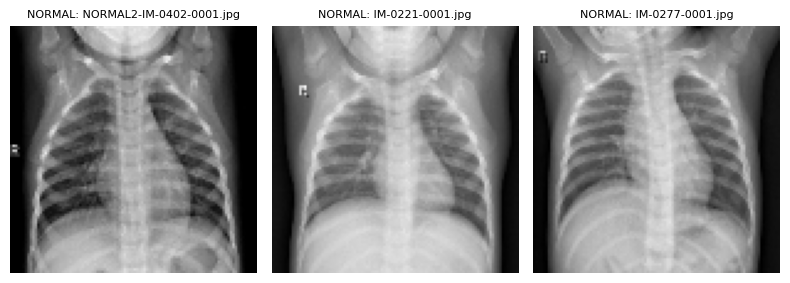

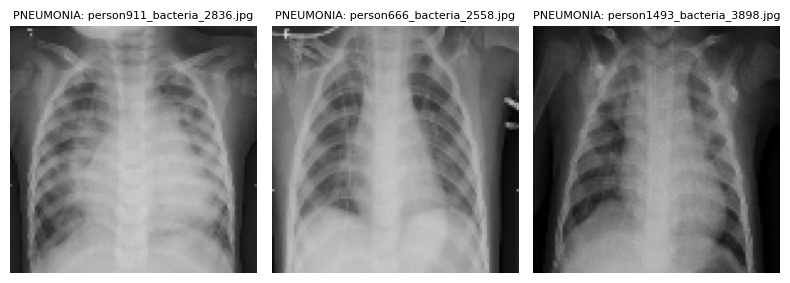


Sample images from Testing dataset:


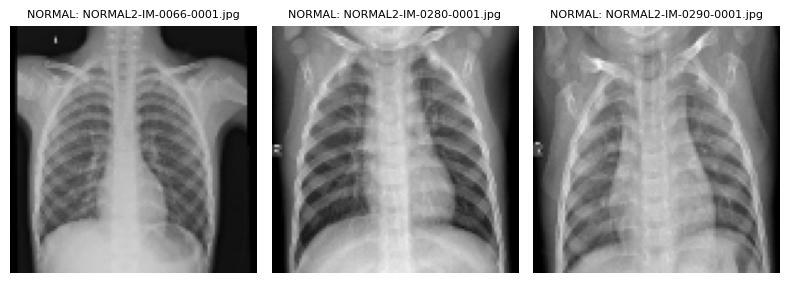

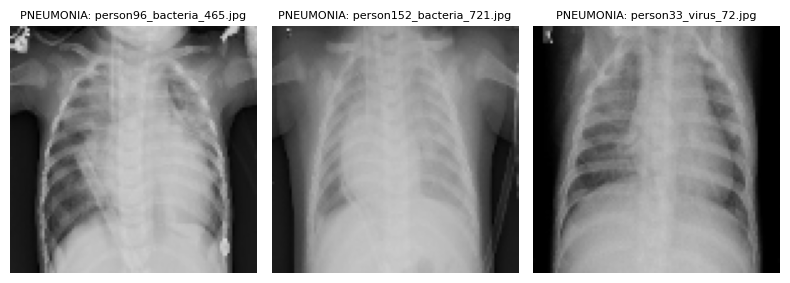


Sample images from Validation dataset:


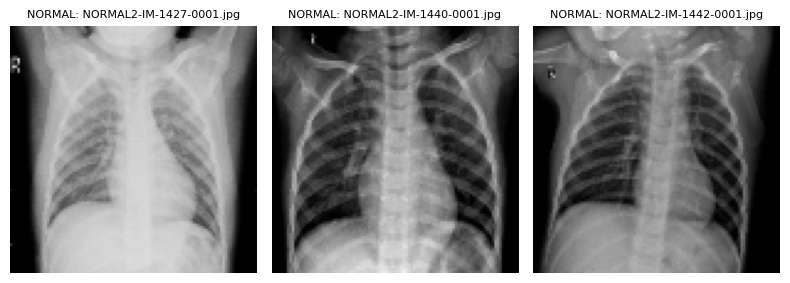

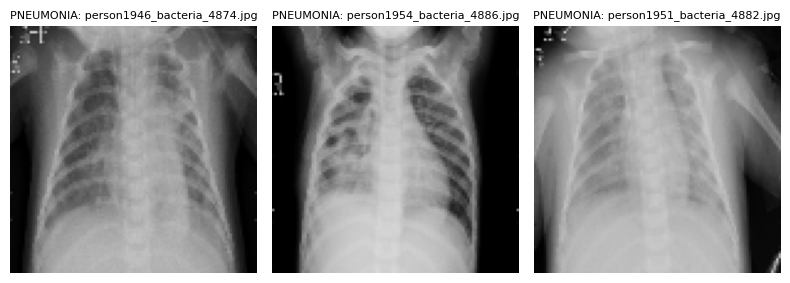

In [ ]:
import matplotlib.pyplot as plt
import os
import cv2
import random

# Function to display sample images with smaller sizes and smaller font size for titles
def display_sample_images(dataset_dir, categories, num_samples=3):
    """
    Display sample images from the resized dataset.

    Parameters:
    - dataset_dir (str): Directory containing the 'Training', 'Testing', or 'Validation' data.
    - categories (list): List of category names (e.g., ['NORMAL', 'PNEUMONIA']).
    - num_samples (int): Number of sample images to display.
    """
    # Loop through each category
    for category in categories:
        category_dir = os.path.join(dataset_dir, category)

        # Get a random sample of image files
        image_files = os.listdir(category_dir)
        sample_images = random.sample(image_files, num_samples)

        # Display sample images
        plt.figure(figsize=(8, 4))  # Adjust the figure size for smaller images

        for i, img_file in enumerate(sample_images):
            img_path = os.path.join(category_dir, img_file)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct display

            # Resize the image to make it smaller within the subplot
            img_resized = cv2.resize(img_rgb, (100, 100))  # Resize to 100x100 for smaller image

            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img_resized)
            plt.title(f'{category}: {img_file}', fontsize=8)  # Decrease the font size
            plt.axis('off')  # Hide axes

        plt.tight_layout()  # Adjust spacing between images
        plt.show()

# Define directories for the resized data
output_base_dir = '/content/drive/My Drive/chest_xray_resized'

train_resized_dir = os.path.join(output_base_dir, 'Training')
test_resized_dir = os.path.join(output_base_dir, 'Testing')
val_resized_dir = os.path.join(output_base_dir, 'Validation')

# Categories
categories = ['NORMAL', 'PNEUMONIA']

# Display sample images from the Training dataset
print("Sample images from Training dataset:")
display_sample_images(train_resized_dir, categories)

# Display sample images from the Testing dataset
print("\nSample images from Testing dataset:")
display_sample_images(test_resized_dir, categories)

# Display sample images from the Validation dataset
print("\nSample images from Validation dataset:")
display_sample_images(val_resized_dir, categories)


# Data Augmentation

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tqdm import tqdm

# Define directories and parameters
input_dir = '/content/drive/My Drive/chest_xray_resized/Training'  # Directory containing the resized training data
output_dir = '/content/drive/My Drive/chest_xray_resized/augmented_training'  # Directory to save augmented images
target_count = 4000  # Desired number of images per category
img_size = 150  # Target size for resizing images

def augment_images(input_dir, output_dir, target_count, img_size):
    """
    Augments images for categories with fewer than target_count images.

    Parameters:
    - input_dir (str): Directory containing resized images.
    - output_dir (str): Directory to save augmented images.
    - target_count (int): Desired number of images per category after augmentation.
    - img_size (int): Target size for resizing images.
    """
    os.makedirs(output_dir, exist_ok=True)  # Create the output directory if it doesn't exist
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.3,
        zoom_range=0.2,
        horizontal_flip=True,  # Horizontal flip is applied
        vertical_flip=False,  # Vertical flip is not applied
        fill_mode='nearest'  # Fill missing pixels after transformation
    )

    # Iterate over 'NORMAL' and 'PNEUMONIA' categories
    for category in ['NORMAL', 'PNEUMONIA']:
        category_input_dir = os.path.join(input_dir, category)  # Input directory for each category
        category_output_dir = os.path.join(output_dir, category)  # Output directory for each category

        os.makedirs(category_output_dir, exist_ok=True)  # Create category-specific output directory

        images = os.listdir(category_input_dir)
        current_count = len(images)
        print(f"Category: {category}, Current Count: {current_count}")

        if current_count < target_count:
            print(f"Augmenting images for {category}...")
            # Progress bar for the current category
            with tqdm(total=target_count - current_count, desc=f"Augmenting {category}", unit="image") as pbar:
                while current_count < target_count:
                    for img_name in images:
                        if current_count >= target_count:
                            break
                        img_path = os.path.join(category_input_dir, img_name)
                        img = load_img(img_path, target_size=(img_size, img_size))  # Resize image
                        img_array = img_to_array(img)
                        img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for ImageDataGenerator

                        # Augment the image and save it to the appropriate directory
                        for batch in datagen.flow(img_array, batch_size=1,
                                                  save_to_dir=category_output_dir,
                                                  save_prefix="aug",
                                                  save_format="jpg"):
                            current_count += 1
                            pbar.update(1)
                            if current_count >= target_count:
                                break

    print("Data augmentation completed!")

# Perform data augmentation
augment_images(input_dir, output_dir, target_count, img_size)


Category: NORMAL, Current Count: 1365
Augmenting images for NORMAL...


Augmenting NORMAL: 100%|██████████| 2635/2635 [00:37<00:00, 70.98image/s]


Category: PNEUMONIA, Current Count: 3923
Augmenting images for PNEUMONIA...


Augmenting PNEUMONIA: 100%|██████████| 77/77 [00:00<00:00, 78.90image/s]

Data augmentation completed!


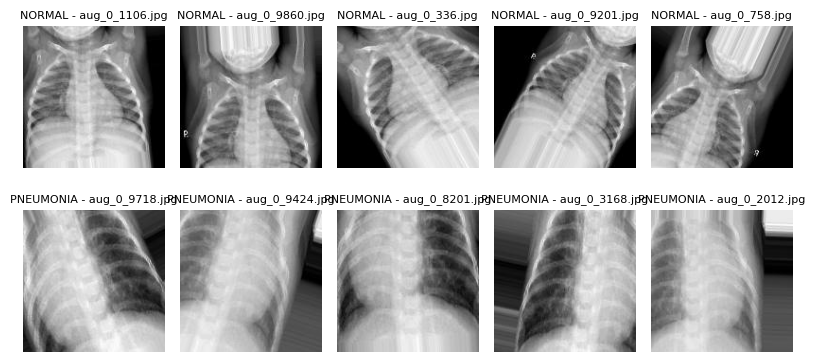

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the directories for augmented images
augmented_dir = '/content/drive/My Drive/chest_xray_resized/augmented_training'
categories = ['NORMAL', 'PNEUMONIA']

# Function to display sample images
def display_sample_images(augmented_dir, categories, num_images=5):
    """
    Displays sample augmented images from the augmented training dataset.

    Parameters:
    - augmented_dir (str): Path to the augmented directory.
    - categories (list): List of categories (subdirectories) to choose images from.
    - num_images (int): Number of images to display.
    """
    plt.figure(figsize=(8, 4))

    # Randomly select images from each category
    for i, category in enumerate(categories):
        category_dir = os.path.join(augmented_dir, category)
        images = os.listdir(category_dir)

        # Select random images
        selected_images = random.sample(images, num_images)

        # Display images
        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(category_dir, img_name)
            img = mpimg.imread(img_path)

            # Plot each image
            plt.subplot(len(categories), num_images, i * num_images + j + 1)
            plt.imshow(img)
            plt.axis('off')  # Hide axes
            plt.title(f"{category} - {img_name}", fontsize=8)  # Smaller font size

    plt.tight_layout()
    plt.show()

# Display 5 sample augmented images from both categories
display_sample_images(augmented_dir, categories, num_images=5)


In [ ]:
import os
import shutil

def combine_images(original_dir, augmented_dir, combined_dir, min_count):
    """
    Combines original images and augmented images, ensuring each category has at least `min_count` images.

    Parameters:
    - original_dir (str): Path to the directory containing original images.
    - augmented_dir (str): Path to the directory containing augmented images.
    - combined_dir (str): Path to the directory where combined images will be saved.
    - min_count (int): Minimum number of images required in each category.

    Returns:
    - None: Prints the final image counts for each category.
    """
    os.makedirs(combined_dir, exist_ok=True)

    # Iterate through the categories in original and augmented directories
    for category in os.listdir(original_dir):
        # Directories for each category
        original_category_dir = os.path.join(original_dir, category)
        augmented_category_dir = os.path.join(augmented_dir, category)
        combined_category_dir = os.path.join(combined_dir, category)
        os.makedirs(combined_category_dir, exist_ok=True)

        # Copy original images
        original_images = os.listdir(original_category_dir)
        for image in original_images:
            src = os.path.join(original_category_dir, image)
            dst = os.path.join(combined_category_dir, image)
            shutil.copy(src, dst)

        # Copy augmented images until the total count reaches `min_count`
        augmented_images = os.listdir(augmented_category_dir)
        total_count = len(original_images)
        for image in augmented_images:
            if total_count >= min_count:
                break
            src = os.path.join(augmented_category_dir, image)
            dst = os.path.join(combined_category_dir, image)
            shutil.copy(src, dst)
            total_count += 1

        # Print final count for the category
        final_count = len(os.listdir(combined_category_dir))
        print(f"Category: {category}, Final Count: {final_count}")

# Define directories and parameters
original_dir = '/content/drive/My Drive/chest_xray_resized/Training'  # Original training dataset directory
augmented_dir = '/content/drive/My Drive/chest_xray_resized/augmented_training'  # Augmented dataset directory
combined_dir = '/content/drive/My Drive/chest_xray_resized/combined_training'  # Combined dataset directory
min_count = 4000  # Minimum images required per category (adjust as needed)

# Combine images and ensure minimum count
combine_images(original_dir, augmented_dir, combined_dir, min_count)


Category: NORMAL, Final Count: 3693
Category: PNEUMONIA, Final Count: 4000


# Normalization

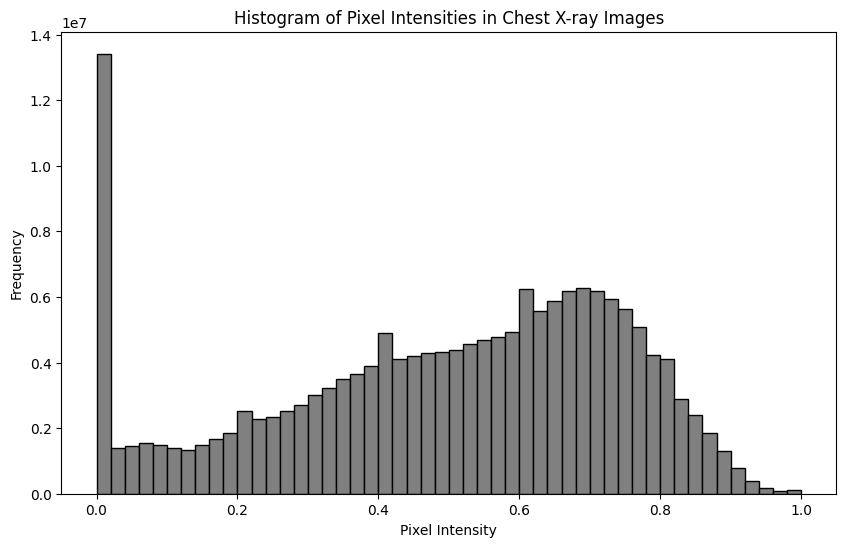

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Function to load images and flatten them into a single array
def load_images_and_labels(dataset_dir, categories, img_size):
    """
    Loads images from the dataset directory and resizes them.

    Parameters:
    - dataset_dir (str): Path to the dataset directory.
    - categories (list): List of category names (e.g., ['NORMAL', 'PNEUMONIA']).
    - img_size (int): Size to resize images.

    Returns:
    - x_data (np.ndarray): Array of image data.
    - y_labels (np.ndarray): Array of one-hot encoded labels.
    """
    x_data = []
    y_labels = []

    # Loop through categories and load images
    for category in categories:
        category_dir = os.path.join(dataset_dir, category)
        for img_name in os.listdir(category_dir):
            img_path = os.path.join(category_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
            img = cv2.resize(img, (img_size, img_size))  # Resize image
            x_data.append(img)
            y_labels.append(category)  # Add the category to the labels list

    # Convert lists to numpy arrays
    x_data = np.array(x_data)
    y_labels = np.array(y_labels)

    return x_data, y_labels

# Set the path to the dataset and categories
dataset_dir = '/content/drive/My Drive/chest_xray_resized/combined_training'
categories = ['NORMAL', 'PNEUMONIA']
img_size = 150  # Resize image to 150x150

# Load images and labels
x_train, y_train = load_images_and_labels(dataset_dir, categories, img_size)

# Normalize the pixel values to [0, 1] range
x_train = x_train.astype('float32') / 255.0  # Normalize pixel values to [0, 1]

# Flatten the images into a single array for histogram plotting
pixel_values = x_train.flatten()

# Plot the histogram of pixel intensities
plt.figure(figsize=(10, 6))
plt.hist(pixel_values, bins=50, color='gray', edgecolor='black')
plt.title('Histogram of Pixel Intensities in Chest X-ray Images')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()


We can infer from the graph that pixels having an intensity of 0 (black or near-black pixels in greyscale) occur alot more than other pixel intensities Why are such pixels so prominent in the images?  After viewing the pixel intensity distribution, we can deduce that Min-Max Normalization might not be suitable in this case because the pixel intensity distribution is heavily skewed toward the lower end (with many 0 values). This could cause the lower range of pixels to dominate the normalization process, leading to loss of information.